In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import cm
import pymc3 as pm
import arviz as az
import seaborn as sns

# Exercise session 4: Normal-normal

* Derive a normal-normal probabilistic model for the heigth of the Swiss population compatible with the following prior assumptions:

1. The mean height of the population lies with 99% probability between 160 and 190 cm
2. The heigth of each individual lies with 99% probability between 100 and 250 cm

Treat the population mean *and* standard deviation as random variables.

The observed values are 168, 178

In [2]:
y = np.array([168, 178])

The probabilistic model is:

\begin{align}
 \mu    & \sim N(\mu_\mu, \sigma_\mu)\\
 \sigma & \sim \textrm{Half-Normal}(\xi)\\
 \vec{y} & \sim N(\mu, \sigma)
\end{align}


The prior mean of the population mean $\mu_\mu$ could be set to (190 + 160)/2 = 175 cm. <br/>
The prior standard deviation of the population mean $\sigma_\mu$ could be set to (190 -175)/3 = 5 cm. <br/>
A plausible value for the standard deviation $\sigma$ of the individuals within the population is (250-100)/6 = 25. A half-normal distribution with scale parameter $38$ has median approximately equal to 25. Then, we can set $\xi=38$

* Implement the model in pymc3

In [3]:
mu_mu = 175 # mean of the prior mean's distribution
sigma_mu = 5 # standard deviation of the prior mean's distribution 
xi = 38 # scale parameter of the prior population's standard deviation
#pd.DataFrame(stats.halfnorm.rvs(size=1000, scale=38)).median() # approx 24

In [4]:
with pm.Model() as model_height:

    # prior distribution
    mu = pm.Normal('mu', mu_mu, sigma_mu) # prior meam
    sigma = pm.HalfNormal('sigma', sd=38) # prior std

    # observation model (likelihood)
    y_obs = pm.Normal('y_obs', mu=mu, sd=sigma, observed=y)
    
    trace_height = pm.sample(return_inferencedata=True, draws=2000, tune=2000) # defaults: 1000, 1000

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.


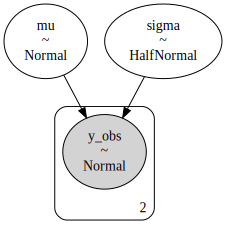

In [5]:
pm.model_to_graphviz(model_height) # pip install graphviz, apt-get install graphviz (on ubuntu)

In [6]:
with model_height:
    display(az.summary(trace_height))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,174.263,4.108,166.584,182.360,0.094,0.066,1931.0,1868.0,1.0
sigma,14.161,11.840,2.359,35.714,0.259,0.183,1970.0,2164.0,1.0


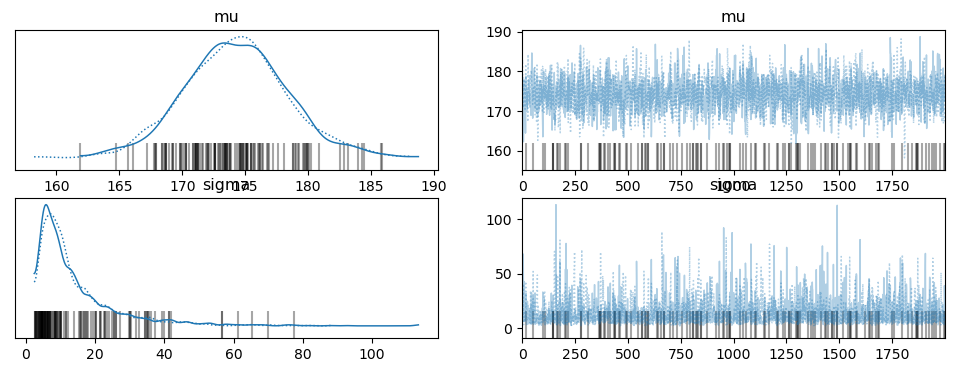

In [7]:
with model_height:
    az.plot_trace(trace_height);

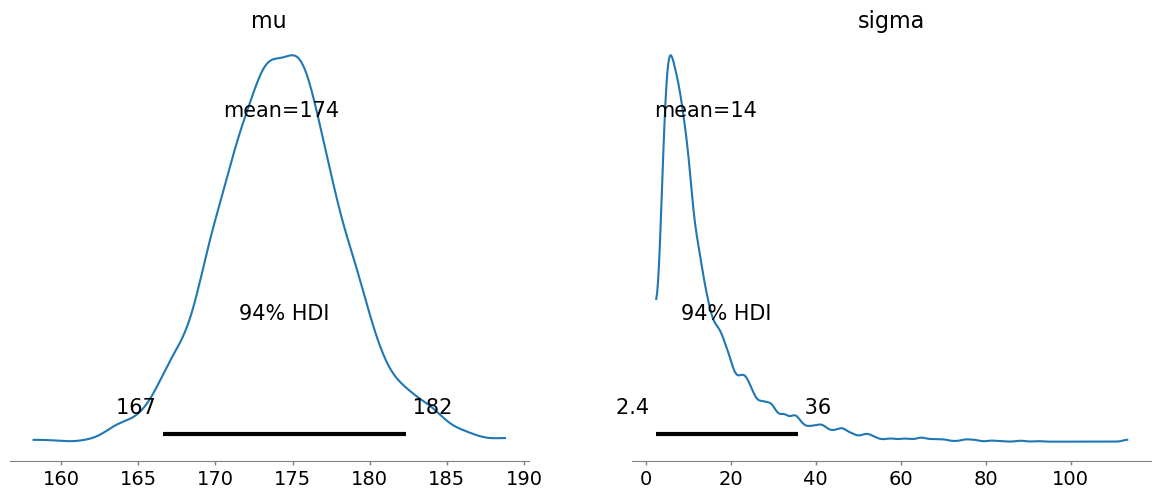

In [8]:
with model_height:
    az.plot_posterior(trace_height);

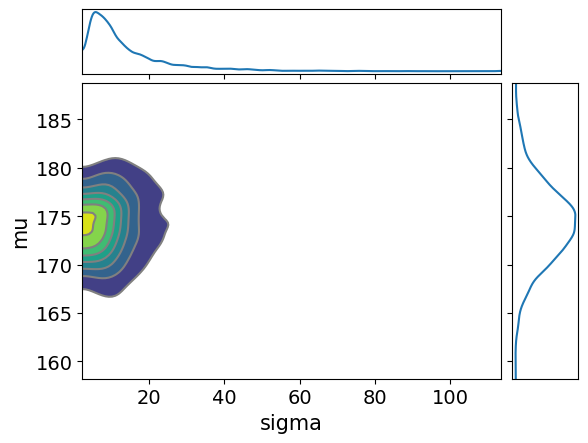

In [9]:
with model_height:
    az.plot_pair(trace_height,
                 kind="kde", # scatter, hexbin, kde
                 var_names=["sigma", "mu"], 
                 marginals=True);

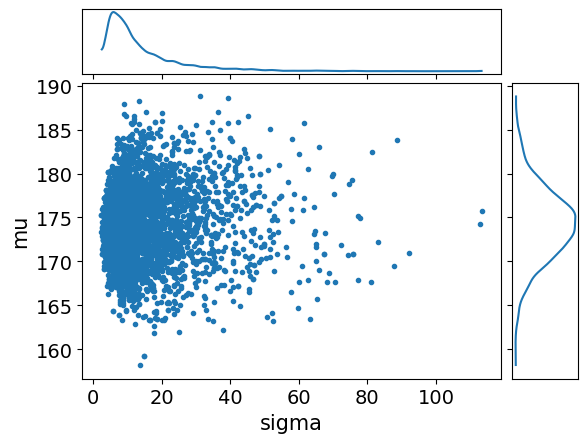

In [10]:
with model_height:
    az.plot_pair(trace_height,
                 kind="scatter", 
                 var_names=["sigma", "mu"], 
                 marginals=True);

* Visualize the prior density $f(\mu, \sigma)$ in 2D

In [11]:
prior_mu = stats.norm(loc=mu_mu, scale=sigma_mu)
prior_sigma = stats.halfnorm(scale=xi)

def prior_pdf_fun(mu, sigma):
    return prior_mu.pdf(mu)*prior_sigma.pdf(sigma)

mu_vec = np.linspace(145, 205, 100)
sigma_vec = np.linspace(0.01, 100, 120)
prior_pdf_mat = np.zeros((len(mu_vec), len(sigma_vec))) 



for mu_idx, mu_val in enumerate(mu_vec):
    for sigma_idx, sigma_val in enumerate(sigma_vec):
        prior_pdf_mat[mu_idx, sigma_idx] = prior_pdf_fun(mu_val, sigma_val) #prior_mu.pdf(mu_val)*prior_sigma.pdf(sigma_val)

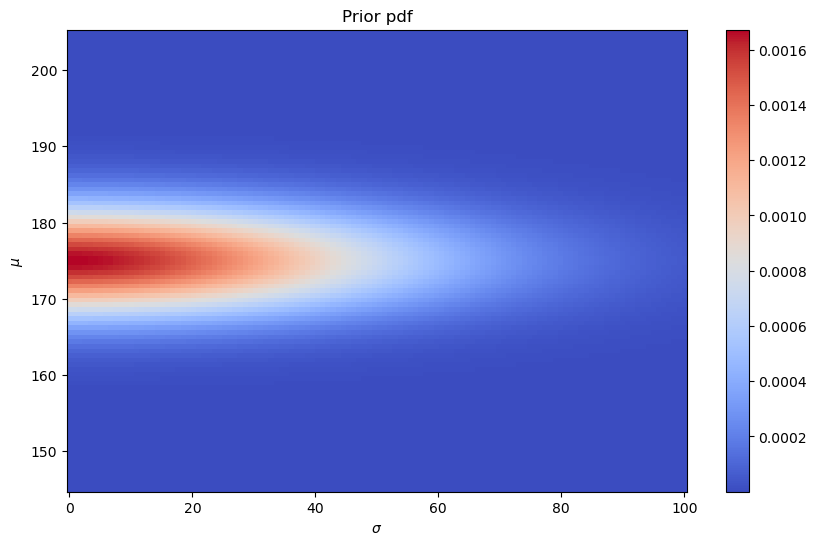

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(sigma_vec, mu_vec, prior_pdf_mat, cmap=cm.coolwarm, shading='auto')
fig.colorbar(c, ax=ax)
ax.set_title(f"Prior pdf")
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$\mu$");

* Obtain a gridding approximation of the posterior $f(\mu, \sigma | \vec{y})$ and visualize it in 2D.

In [13]:
def lik_fun(mu, sigma, observed=y):
    return np.prod(stats.norm.pdf(observed, loc=mu, scale=sigma))

mu_vec = np.linspace(145, 205, 100); dmu = np.diff(mu_vec)[0]
sigma_vec = np.linspace(0.01, 100, 120); dsigma = np.diff(sigma_vec)[0]
post_pdf_mat = np.zeros((len(mu_vec), len(sigma_vec))) 

for mu_idx, mu_val in enumerate(mu_vec):
    for sigma_idx, sigma_val in enumerate(sigma_vec):
        post_pdf_mat[mu_idx, sigma_idx] = prior_pdf_fun(mu_val, sigma_val) * \
             lik_fun(mu_val, sigma_val, observed=y)
        #prior_f = prior_mu.pdf(mu_val) * prior_sigma.pdf(sigma_val)
        #lik = np.prod(stats.norm.pdf(y, loc=mu_val, scale=sigma_val))
        #post_pdf_mat[mu_idx, sigma_idx] = prior_f * lik

post_pdf_mat = post_pdf_mat/(np.sum(post_pdf_mat)*dmu*dsigma) # normalization

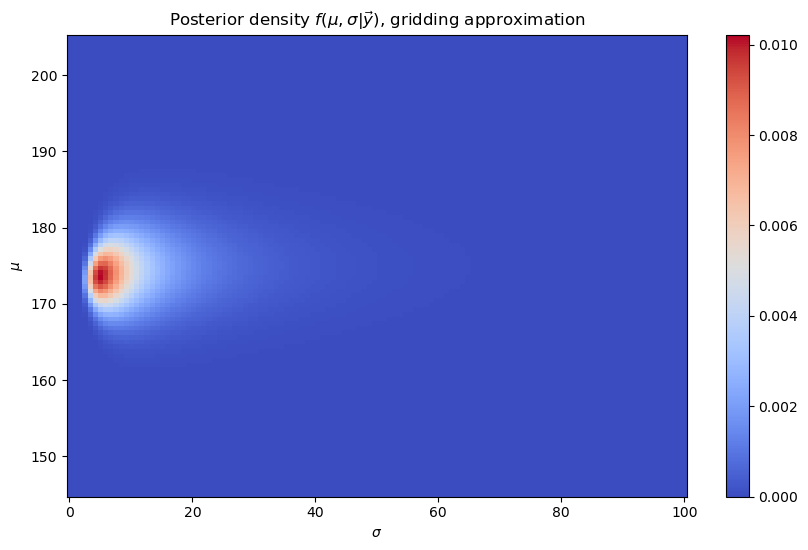

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(sigma_vec, mu_vec, post_pdf_mat, cmap=cm.coolwarm, shading='auto')
fig.colorbar(c, ax=ax)
ax.set_title(r"Posterior density $f(\mu, \sigma | \vec{y})$, gridding approximation")
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$\mu$");

The gridding posterior may be compared with the MC samples from pymc3

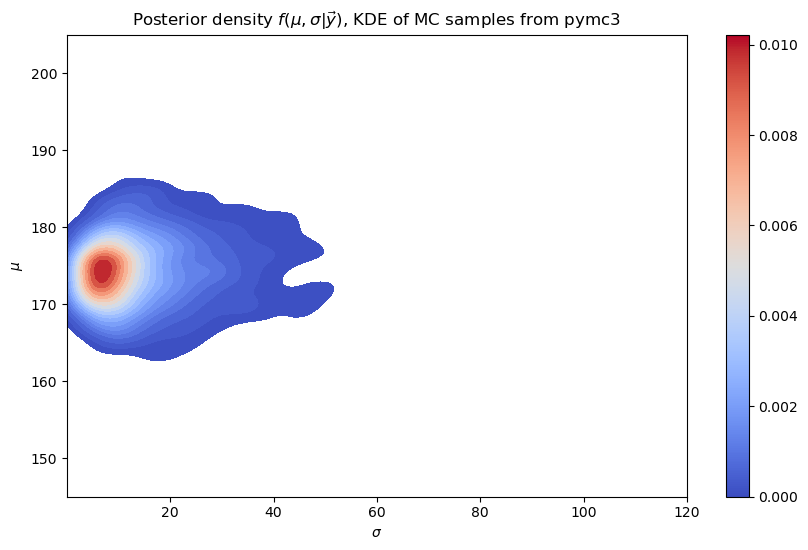

In [15]:
post_samples = az.extract_dataset(trace_height.posterior)
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(x=post_samples.sigma.values, y=post_samples.mu.values,
            fill=True, cmap=cm.coolwarm, levels=20)
fig.colorbar(c, ax=ax)
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$\mu$")
ax.set_xlim([0.01, 120])
ax.set_ylim([145, 205])
plt.title(r"Posterior density $f(\mu, \sigma | \vec{y})$, KDE of MC samples from pymc3");

There seems to be an excellent match!

* Obtain a gridding approximation of the posterior $f(\mu, \sigma | \vec{y})$ using a log-domain implementation. Visualize the result in 2D.

In [16]:
def post_logpdf_fun(mu, sigma, observed=y):
    log_prior = prior_mu.logpdf(mu) + prior_sigma.logpdf(sigma)
    log_lik = np.sum(stats.norm.logpdf(observed, loc=mu, scale=sigma))
    log_post = log_prior + log_lik
    return log_post

mu_vec = np.linspace(145, 205, 100); dmu = np.diff(mu_vec)[0]
sigma_vec = np.linspace(0.01, 100, 120); dsigma = np.diff(sigma_vec)[0]
post_logpdf_mat = np.zeros((len(mu_vec), len(sigma_vec))) 

prior_mu = stats.norm(loc=mu_mu, scale=sigma_mu)
prior_sigma = stats.halfnorm(scale=xi)

for mu_idx, mu_val in enumerate(mu_vec):
    for sigma_idx, sigma_val in enumerate(sigma_vec):
        post_logpdf_mat[mu_idx, sigma_idx] = post_logpdf_fun(mu_val, sigma_val, observed=y)

# from log pdf to pdf, robust way
post_logpdf_mat = post_logpdf_mat - np.max(post_logpdf_mat) # shift the logpdf to have a maximum of 0
post_pdf_mat = np.exp(post_logpdf_mat) # exponentiate safely (maximum value is exp(0)=1)
post_pdf_mat = post_pdf_mat/(np.sum(post_pdf_mat)*dmu*dsigma) # normalize to a distribution

# with the logsumexp magic, we could do it in one shot!
#post_pdf_mat_ = np.exp(post_logpdf_mat - scipy.special.logsumexp(post_logpdf_mat))/(dmu*dsigma)

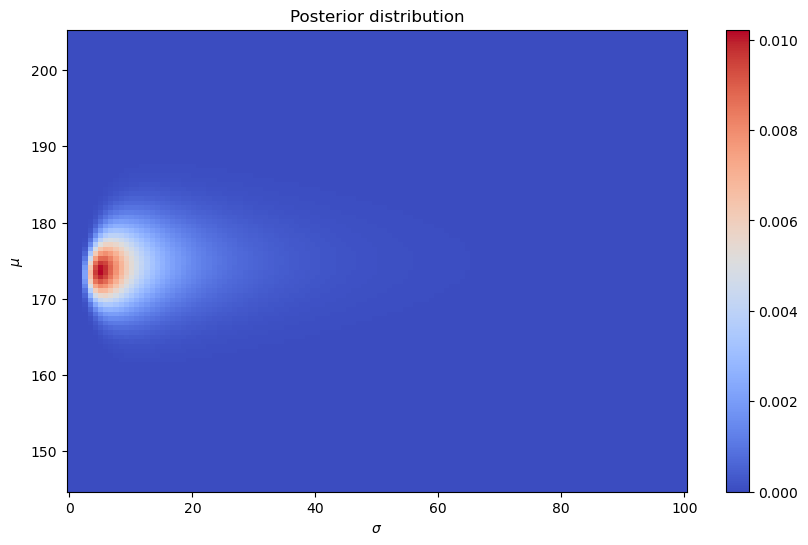

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(sigma_vec, mu_vec, post_pdf_mat, cmap=cm.coolwarm, shading='auto')
fig.colorbar(c, ax=ax)
ax.set_title(f"Posterior distribution")
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$\mu$");

* What happens to the two gridding approximations (in pdf and log-pdf domain) if the observation is `y_long` defined below?

In [18]:
y_long = np.repeat(y, 200) # A much longer observation. 

In [19]:
mu_vec = np.linspace(145, 205, 100); dmu = np.diff(mu_vec)[0]
sigma_vec = np.linspace(0.01, 100, 120); dsigma = np.diff(sigma_vec)[0]
post_pdf_mat = np.zeros((len(mu_vec), len(sigma_vec))) 

for mu_idx, mu_val in enumerate(mu_vec):
    for sigma_idx, sigma_val in enumerate(sigma_vec):
        post_pdf_mat[mu_idx, sigma_idx] = prior_pdf_fun(mu_val, sigma_val) * \
             lik_fun(mu_val, sigma_val, observed=y_long)

post_pdf_mat = post_pdf_mat/(np.sum(post_pdf_mat)*dmu*dsigma) # normalization

/tmp/ipykernel_11479/4086172325.py:10: RuntimeWarning: invalid value encountered in true_divide
  post_pdf_mat = post_pdf_mat/(np.sum(post_pdf_mat)*dmu*dsigma) # normalization


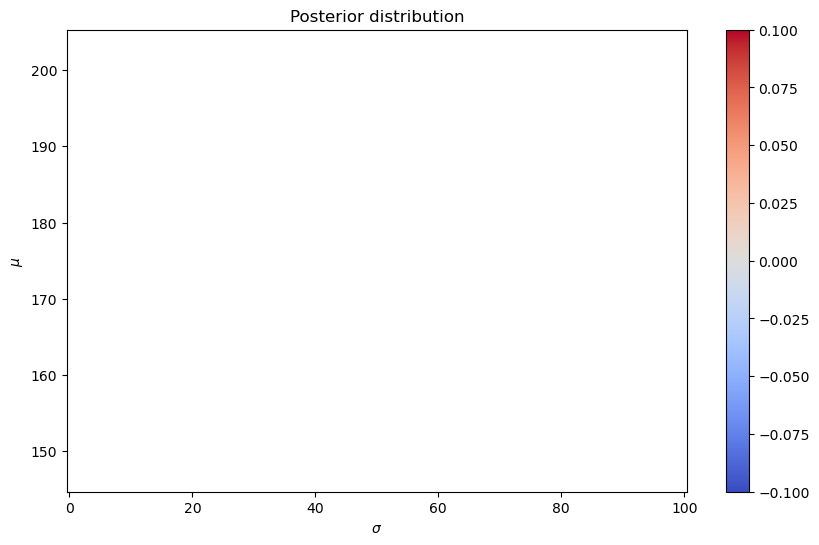

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(sigma_vec, mu_vec, post_pdf_mat, cmap=cm.coolwarm, shading='auto')
fig.colorbar(c, ax=ax)
ax.set_title(f"Posterior distribution")
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$\mu$");

The implementation without log fails miserably!

In [21]:
def post_logpdf_fun(mu, sigma, observed=y):
    log_prior = prior_mu.logpdf(mu) + prior_sigma.logpdf(sigma)
    log_lik = np.sum(stats.norm.logpdf(observed, loc=mu, scale=sigma))
    log_post = log_prior + log_lik
    return log_post

mu_vec = np.linspace(145, 205, 100); dmu = np.diff(mu_vec)[0]
sigma_vec = np.linspace(0.01, 100, 120); dsigma = np.diff(sigma_vec)[0]
#mu_vec = np.linspace(172, 174, 100); dmu = np.diff(mu_vec)[0]
#sigma_vec = np.linspace(2.0, 8.0, 120); dsigma = np.diff(sigma_vec)[0]
post_logpdf_mat = np.zeros((len(mu_vec), len(sigma_vec))) 

prior_mu = stats.norm(loc=mu_mu, scale=sigma_mu)
prior_sigma = stats.halfnorm(scale=xi)

for mu_idx, mu_val in enumerate(mu_vec):
    for sigma_idx, sigma_val in enumerate(sigma_vec):
        post_logpdf_mat[mu_idx, sigma_idx] = post_logpdf_fun(mu_val, sigma_val, observed=y_long)

post_logpdf_mat = post_logpdf_mat - np.max(post_logpdf_mat) # shift the distributions to have a maximum of 0

post_pdf_mat = np.exp(post_logpdf_mat)
post_pdf_mat = post_pdf_mat/(np.sum(post_pdf_mat)*dmu*dsigma)

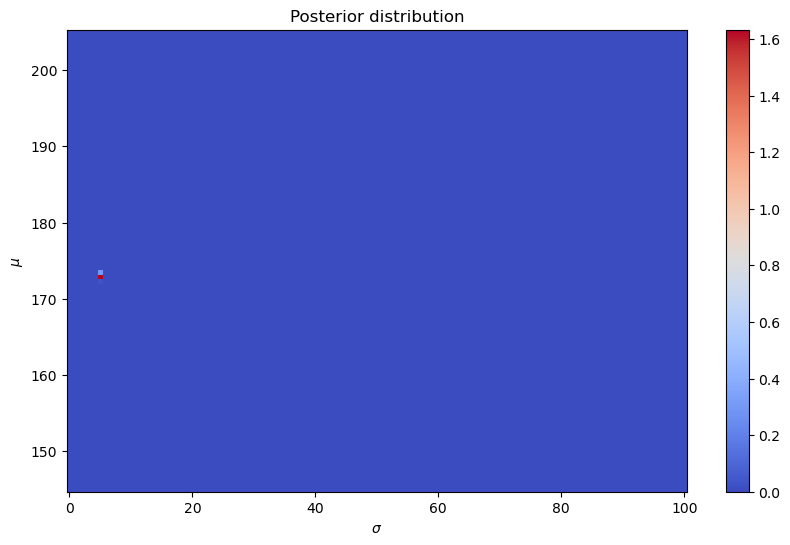

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(sigma_vec, mu_vec, post_pdf_mat, cmap=cm.coolwarm, shading='auto')
fig.colorbar(c, ax=ax)
ax.set_title(f"Posterior distribution")
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$\mu$");

The implementation in the log domain still works. Perhaps we can choose a better grid range...

* Implement a faster gridding method avoiding slow Python loops, using *vectorized* operations.

In [23]:
def log_post_fun_vectorized(mu, sigma, observed=y):
    log_prior = prior_mu.logpdf(mu) + prior_sigma.logpdf(sigma)
    log_lik = np.sum(stats.norm.logpdf(observed, loc=mu, scale=sigma), axis=-1, keepdims=True)
    log_post = log_prior + log_lik
    return log_post

mu_vec = np.linspace(145, 205, 1000); dmu = np.diff(mu_vec)[0]
sigma_vec = np.linspace(0.01, 100, 1200); dsigma = np.diff(sigma_vec)[0]

SIGMA, MU = np.meshgrid(sigma_vec, mu_vec, indexing='xy')
post_logpdf_mat = log_post_fun_vectorized(MU[:, :, np.newaxis], SIGMA[:, :, np.newaxis], observed=y)
post_logpdf_mat = post_logpdf_mat.squeeze() # remove useless trailing dimension
post_logpdf_mat -= np.max(post_logpdf_mat) # shift the distributions to have a maximum of 0
post_pdf_mat = np.exp(post_logpdf_mat)
post_pdf_mat /= (np.sum(post_pdf_mat) * dmu * dsigma)

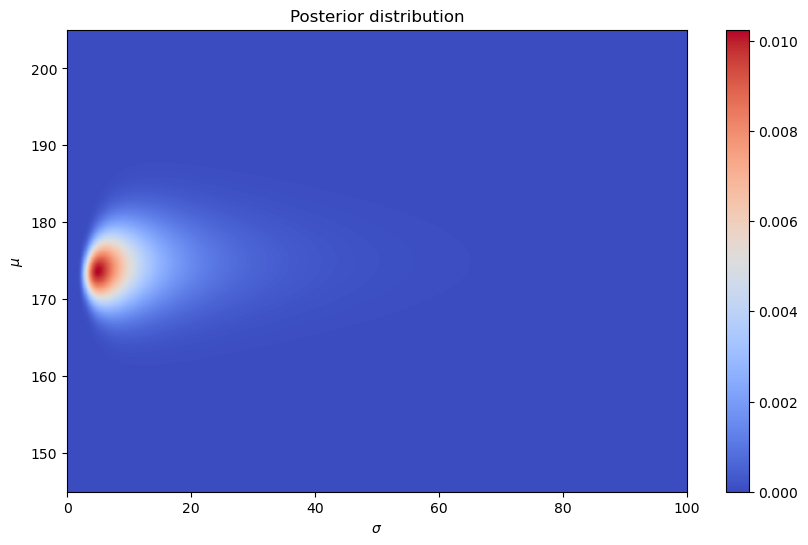

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(SIGMA, MU, post_pdf_mat, cmap=cm.coolwarm, shading='auto')
fig.colorbar(c, ax=ax)
ax.set_title(f"Posterior distribution")
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$\mu$");

The vectorized implementation is much faster ($\approx$ 100x!) and we can use a finer grid. Still, we would be out of business for higher-dimensional problems...

* Obtain a sample-based approximation of the posterior implementing Metropolis from scratch.

In [25]:
def p_ratio_fun(mu_propose, sigma_propose, mu_previous, sigma_previous):
    log_p_propose = post_logpdf_fun(mu_propose, sigma_propose, observed=y)
    log_p_previous = post_logpdf_fun(mu_previous, sigma_previous, observed=y)
    log_p_ratio = log_p_propose - log_p_previous 
    p_ratio = np.exp(log_p_ratio)
    return p_ratio

In [26]:
draws = 4_000 # number of Metropolis draws
tune = 1_000 # tuning samples to be discarded
mu_0 = 175.0 # initial value for mu
sigma_0 = 10.0 # initial value for sigma

sigma_prop_mu = 2.0 # standard deviation of the proposal for mu
sigma_prop_sigma = 5.0 # standard deviation of the proposal for sigma

N = draws + tune
mus = []
sigmas = []
mu_step = mu_0
sigma_step = sigma_0
for idx in range(N):
    mus.append(mu_step)
    sigmas.append(sigma_step)

    mu_prop = mu_step + sigma_prop_mu * np.random.randn()
    sigma_prop = sigma_step + sigma_prop_sigma * np.random.randn()
  
    p_ratio = p_ratio_fun(mu_prop, sigma_prop, mu_step, sigma_step)
    accept_prob = np.minimum(1.0, p_ratio)
    accept = (np.random.rand() < accept_prob)
    
    if accept:
        mu_step = mu_prop
        sigma_step = sigma_prop

mus = np.array(mus[tune:]) # discard initial samples (burn-in)
sigmas = np.array(sigmas[tune:])
thetas = np.c_[mus, sigmas]

In [27]:
np.mean(thetas, axis=0) # result similar to pymc3!

array([174.74741415,  13.63974951])

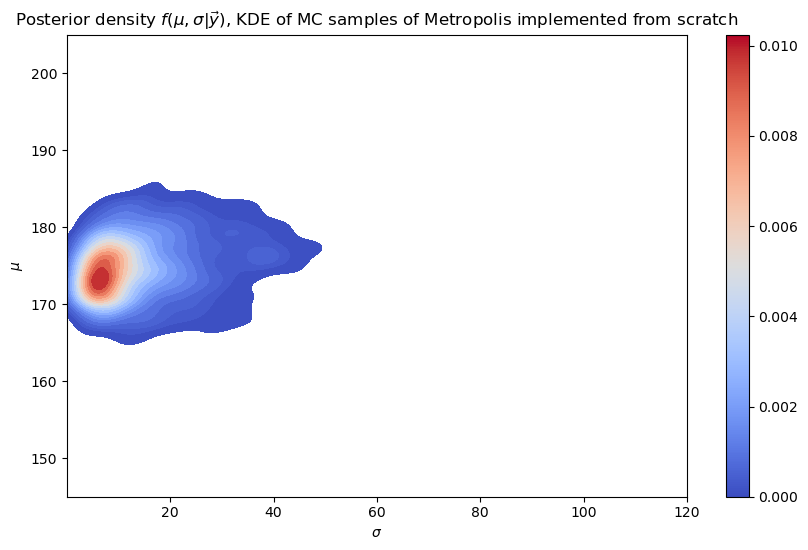

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(x=sigmas, y=mus,
            fill=True, cmap=cm.coolwarm, levels=20)
fig.colorbar(c, ax=ax)
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$\mu$")
ax.set_xlim([0.01, 120])
ax.set_ylim([145, 205])
plt.title(r"Posterior density $f(\mu, \sigma | \vec{y})$, KDE of MC samples of Metropolis implemented from scratch");

In [29]:
#fig, ax = plt.subplots(figsize=(10, 6))
#az.plot_kde(sigmas, mus, contour_kwargs={"colors":None, "cmap":cm.coolwarm, "levels": 10})
#ax.set_xlabel(r"$\sigma$")
#ax.set_ylabel(r"$\mu$")
#ax.set_xlim([0.01, 120])
#ax.set_ylim([145, 205])
#fig.colorbar(c, ax=ax);

* Compare the solutions obtained with the different techniques (gridding, metropolis, pymc3).